# Scenarios, MC estimation

In [22]:
from scipy import stats
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
import pickle

from tqdm import tqdm_notebook as tqdm

In [2]:
def display1(out) :
    plt.figure(figsize=(15,4.5))
    plt.suptitle(r"Coallition $k_1={}$ vs Coallition $k_2={}$".format(out['k1'],out['k2']))
    v_ = np.linspace(0,1,1001)
        
    plt.subplot(131)
    
    plt.semilogy(np.linspace(0,out['tstar'],out['N']+2),out['delta1_'],'b',label=r'$\delta_1$')
    plt.semilogy(np.linspace(0,out['tstar'],out['N']+2),out['delta2_'],'r',label=r'$\delta_2$')
    plt.axhline(out['l1'],color='b',linestyle='--')
    plt.axhline(1/out['tstar'],color='gray',linestyle='--')
    plt.axhline(out['l2'],color='r',linestyle='--')
    plt.ylim((min(out['l2'],out['l1'])-0.1,max(out['l2'],out['l1'])+0.1))
    
    plt.axvline(out['tstar']*out['breakpoint']/(out['N']+1),color='k',linewidth=2)
    
    plt.title(r"Approximated functions : $\delta_i(b) = \lambda_i(b)/b$")
    plt.legend()
    
    plt.subplot(132)
    b_ = np.linspace(0,out['tstar'],out['N']+2)
    plt.plot(b_,out['values1_'],'b',label=r'$\lambda_1$')
    plt.plot(b_,out['values2_'],'r',label=r'$\lambda_2$')
    plt.plot(b_,out['l1']*b_,'b--')
    plt.plot(b_,out['l2']*b_,'r--')
    
    plt.title(r"Value functions $\lambda_i$")
    plt.legend()
    plt.xlim((0,out['tstar']))
    plt.grid(True, which='both')
    
    plt.subplot(133)
    plt.plot(v_,[bid1_f(v,out) for v in v_],'b',label=r"$\phi_1$")
    plt.plot(v_,[bid2_f(v,out) for v in v_],'r',label=r"$\phi_2$")
    plt.plot(v_,1/out['l1']*v_,'b--')
    plt.plot(v_,1/out['l2']*v_,'r--')
    plt.axhline(out['tstar'],color='gray',linestyle='--')
    
    plt.title(r"Bid functions $\phi_i$")
    plt.legend()
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.grid(True, which='both')
    
    plt.show()

In [3]:
def BR_f_OPTIMIZE(v,rv) :
    """
    Using optimize.minimize, it returns the best response function against the NON-NEGATIVE random variable rv :
    v \mapsto argmax_b (v-b)G(b)
    where G is the cdf of rv
    """
    minus_utility_v = lambda b : -(v-b)*rv.cdf(b)
    opt = optimize.minimize_scalar(minus_utility_v,method="bounded",bracket=(0,1),bounds=(0,1))
    return opt.x

In [4]:
def BR_(rv,N=10_000) :
    br_ = np.zeros(N)
    for i in range(N+1) :
        br_[i] = BR_at_against(i/(N+1),rv,y_ub=y_ub)
    return br_

In [5]:
def iBR_f(b,br_) :
    return np.searchsorted(br_,b)/(len(br_)+1)

In [6]:
def bid1_f(v,method_out) :
    return method_out['tstar']*np.searchsorted(method_out['values1_'],v)/(method_out['N']+1)

def bid2_f(v,method_out) :
    return method_out['tstar']*np.searchsorted(method_out['values2_'],v)/(method_out['N']+1)

### Marshall1994  : Coallition vs Coallition

In [7]:
def marshall1_sub_method(tstar,k1,k2,N=10_000,p=5,correct=True) :
    l1 = 1+1/k2
    l2 = 1+1/k1
    
    output = {}
    output['tstar'] = tstar
    output['N']=N
    output['breakpoint'] = 0
    output['l1'] = l1
    output['l2'] = l2
    output['k1'] = k1
    output['k2'] = k2
    
    delta1_ = np.zeros(N+2)
    delta2_ = np.zeros(N+2)

    a_ = np.zeros(p+1)
    b_ = np.zeros(p+1)
    
    delta1_[N+1] = 1/tstar
    delta2_[N+1] = 1/tstar
    
    for j in np.arange(N+1,0,-1) : #j=N+1,...,1
        tj = tstar*j/(N+1)
                    
        #values at tj, equation (17)
        a_[0] = delta1_[j] 
        b_[0] = delta2_[j]
        
        ## updating the Taylors approximations astar_,bstar_ equations (19, 20)
        
        for l in range(p) :
            sum1 = np.sum([i*b_[l+1-i]*( a_[i-1]+tj*a_[i]) for i in range(1,l+1)])
            sum2 = np.sum([i*a_[l+1-i]*( b_[i-1]+tj*b_[i]) for i in range(1,l+1)])
    
            a_[l+1] = 1/((l+1)*(b_[0]-1)*tj) * ( (1/k1-(l+1)*(b_[0]-1))*a_[l]-sum1 )
            b_[l+1] = 1/((l+1)*(a_[0]-1)*tj) * ( (1/k2-(l+1)*(a_[0]-1))*b_[l]-sum2 )
        
        tjm1 = tstar*(j-1)/(N+1)
            
        delta1_[j-1] = np.polynomial.polynomial.polyval(tjm1-tj,a_) #updating at tj-1
        delta2_[j-1] = np.polynomial.polynomial.polyval(tjm1-tj,b_)
        
        if(output['breakpoint'] == 0 and ((delta1_[j-1]-l1)**2+(delta2_[j-1]-l2)**2 > ((delta1_[j]-l1)**2+(delta2_[j]-l2)**2))) :
            output['breakpoint'] = j
            if(correct) :
                break
    
    output['eps_star'] = np.sqrt(((delta1_[output['breakpoint']]-l1)**2+(delta2_[output['breakpoint']]-l2)**2))
    #output['precision'] = np.min(((delta1_-l1)**2+(delta2_-l2)**2))
    if(correct) :
        ind = output['breakpoint']
        delta1_[:ind+1] = np.linspace(l1,delta1_[ind],ind+1)
        delta2_[:ind+1] = np.linspace(l2,delta2_[ind],ind+1)
        
        #patch_ = 1/(np.linspace(0,out['tstar'],out['N']+2)[1:])
        #delta1_[1:] = np.where(delta1_[1:] > patch_, patch_,delta1_[1:])
        #delta2_[1:] = np.where(delta2_[1:] > patch_, patch_,delta2_[1:])
        
    output['delta1_']=delta1_
    output['delta2_']=delta2_
    output['values1_']=np.linspace(0,tstar,N+2)*delta1_
    output['values2_']=np.linspace(0,tstar,N+2)*delta2_
    return output

In [8]:
def marshall1_iterative_find_boundary_CUSTOM(k1,k2,eps=10**-5,nb_eval_max=500,N=10_000,p=5,show_msg=False) :
    l1 = 1+1/k2
    l2 = 1+1/k1
    
    a = min(1/l1,1/l2)
    b = max(1/l1,1/l2)
    
    tau = (np.sqrt(5)-1)/2
    
    x_1 = a + (1-tau)*(b-a)
    f_1 = marshall1_sub_method(x_1,k1,k2,N,p,correct=True)
    
    x_2 = a + tau*(b-a)
    f_2 = marshall1_sub_method(x_2,k1,k2,N,p,correct=True)
    
    i=2
    while(f_1['eps_star']>eps and f_2['eps_star']>eps and i < nb_eval_max) :
        if(f_1['eps_star'] > f_2['eps_star']) :
            a = x_1
            x_1 = x_2
            f_1 = f_2
            x_2 = a + tau*(b-a)
            f_2 = marshall1_sub_method(x_2,k1,k2,N,p,correct=True)
        else :
            b = x_2
            x_2 = x_1
            f_2 = f_1
            x_1 = a + (1-tau)*(b-a)
            f_1 = marshall1_sub_method(x_1,k1,k2,N,p,correct=True)
        i+=1
    
    if(show_msg) :
        print("Nb of eval :",i)
        print("eps_star :",min(f_1['eps_star'],f_2['eps_star']))
        if(i==nb_eval_max) :
            print("Maximum number of evaluations reached")
            
    if(f_1['eps_star']<f_2['eps_star']) :
        return f_1
    else :
        return f_2

In [9]:
def marshall1_close_form_boundary(k1,k2,N=10_000,p=5,correct=True) :
    tstar = k1/(k1+1)
    
    if(k1!=k2) :
        tstar = 1-np.power(1+k1,k2/(k1-k2))/np.power(1+k2,k1/(k1-k2))*np.power((k2*(1+k1))/(k1*(1+k2)),k1*k2/(k1-k2))
        
    return marshall1_sub_method(tstar,k1,k2,N=N,p=p,correct=correct)

### Marshall1994: Coallition vs Individuals

In [10]:
def marshall2_sub_method(tstar,k1,k2,N=10_000,p=5,correct=True) :
    delta1_ = np.zeros(N+2)
    delta2_ = np.zeros(N+2)
    
    l1 = 1+1/k2
    l2 = 1+1/(k1+k2-1)
    
    output = {}
    output['tstar'] = tstar
    output['N']=N
    output['breakpoint'] = 0
    output['l1'] = l1
    output['l2'] = l2
    
    a_ = np.zeros(p+1)
    b_ = np.zeros(p+1)
    c_ = np.zeros(p+1)
    alpha_ = np.zeros(p+1)
    beta_ = np.zeros(p+1)
    gamma_ = np.zeros(p+1)
    
    theta = (k2-1)/k1
    
    delta1_[N+1] = 1/tstar
    delta2_[N+1] = 1/tstar
    
    for j in np.arange(N+1,0,-1) : #j=N+1,...,1
        tj = tstar*j/(N+1)
                    
        #values at tj, equations (17 (modified, see 26), 36, 37)
        b_[0] = delta2_[j]
        
        #c_[0] = (delta1_[j]**(k1/(k1+k2-1)))*(delta2_[j]**((k2-1)/(k1+k2-1)))
        #a_[0] = c_[0]*(c_[0]/b_[0])**theta
        
        a_[0] = delta1_[j]
        c_[0] = (a_[0]**(k1/(k1+k2-1)))*(b_[0]**((k2-1)/(k1+k2-1)))
        
        alpha_[0] = a_[0]*c_[0]
        beta_[0] = b_[0]*c_[0]
        gamma_[0] = a_[0]*b_[0]
        
        ## updating the Taylors approximations equations (16, 33, 34, 35)
        for l in range(p) :
            sum_b = np.sum([i*a_[l+1-i]*( b_[i-1]+tj*b_[i]) for i in range(1,l+1)])    
            b_[l+1] = -b_[l]/tj + 1/((l+1)*(a_[0]-1)*tj) * ( (1/k2)*b_[l]-sum_b )
        
            sum_c = np.sum([i*b_[l+1-i]*( c_[i-1]+tj*c_[i]) for i in range(1,l+1)])
            c_[l+1] = -c_[l]/tj + 1/((l+1)*(b_[0]-1)*tj) * ( (1/(k1+k2-1))*c_[l]-sum_c )
            
            A = np.sum([i*c_[i]*gamma_[l+1-i]-a_[i]*beta_[l+1-i] for i in range(1,l+1)]) 
            B = theta*np.sum([i*c_[i]*gamma_[l+1-i]-b_[i]*alpha_[l+1-i] for i in range(1,l+1)])
            a_[l+1] = c_[l+1]*alpha_[0]/beta_[0]+theta*(c_[l+1]*alpha_[0]/beta_[0]-b_[l+1]*alpha_[0]/beta_[0])+1/((l+1)*beta_[0]) * (A+B)
            
            alpha_[l+1] = np.sum([a_[i]*c_[l+1-i] for i in range(0,l+2)]) 
            beta_[l+1] = np.sum([b_[i]*c_[l+1-i] for i in range(0,l+2)]) 
            gamma_[l+1] = np.sum([a_[i]*b_[l+1-i] for i in range(0,l+2)]) 
        
        tjm1 = tstar*(j-1)/(N+1)
        
        delta1_[j-1] = np.polynomial.polynomial.polyval(tjm1-tj,a_) #updating at tj-1
        delta2_[j-1] = np.polynomial.polynomial.polyval(tjm1-tj,b_)
        
        if(output['breakpoint'] == 0 and ((delta1_[j-1]-l1)**2+(delta2_[j-1]-l2)**2 > ((delta1_[j]-l1)**2+(delta2_[j]-l2)**2))) :
            output['breakpoint'] = j
            if(correct) :
                break
    
    output['eps_star'] = np.sqrt(((delta1_[output['breakpoint']]-l1)**2+(delta2_[output['breakpoint']]-l2)**2))
    #output['precision'] = np.min(((delta1_-l1)**2+(delta2_-l2)**2))
    if(correct) :
        ind = output['breakpoint']
        delta1_[:ind+1] = np.linspace(l1,delta1_[ind],ind+1)
        delta2_[:ind+1] = np.linspace(l2,delta2_[ind],ind+1)
        
        #patch_ = 1/(np.linspace(0,out['tstar'],out['N']+2)[1:])
        #delta1_[1:] = np.where(delta1_[1:] > patch_, patch_,delta1_[1:])
        #delta2_[1:] = np.where(delta2_[1:] > patch_, patch_,delta2_[1:])
        
    output['delta1_']=delta1_
    output['delta2_']=delta2_
    output['values1_']=np.linspace(0,tstar,N+2)*delta1_
    output['values2_']=np.linspace(0,tstar,N+2)*delta2_
    return output

In [11]:
def marshall2_iterative_find_boundary_CUSTOM(k1,k2,eps=10**-5,nb_eval_max=500,N=10_000,p=5,show_msg=False) :
    l1 = 1+1/k2
    l2 = 1+1/(k1+k2-1)
    
    a = 1/l1
    b = 1/l2
    
    tau = (np.sqrt(5)-1)/2
    
    x_1 = a + (1-tau)*(b-a)
    f_1 = marshall2_sub_method(x_1,k1,k2,N,p,correct=True)
    
    x_2 = a + tau*(b-a)
    f_2 = marshall2_sub_method(x_2,k1,k2,N,p,correct=True)
    
    i=2
    while(f_1['eps_star']>eps and f_2['eps_star']>eps and i < nb_eval_max) :
        if(f_1['eps_star'] > f_2['eps_star']) :
            a = x_1
            x_1 = x_2
            f_1 = f_2
            x_2 = a + tau*(b-a)
            f_2 = marshall2_sub_method(x_2,k1,k2,N,p,correct=True)
        else :
            b = x_2
            x_2 = x_1
            f_2 = f_1
            x_1 = a + (1-tau)*(b-a)
            f_1 = marshall2_sub_method(x_1,k1,k2,N,p,correct=True)
        i+=1
    
    if(show_msg) :
        print("Nb of eval :",i)
        print("eps_star :",min(f_1['eps_star'],f_2['eps_star']))
        if(i==nb_eval_max) :
            print("Maximum number of evaluations reached")
            
    if(f_1['eps_star']<f_2['eps_star']) :
        return f_1
    else :
        return f_2

## Scenarios

In [12]:
def scenario0_bids(k,n,v_in_sub_,v_out_) :
    """
    Every player is non-cooperative and plays the NE, (n-1)/n of its value
    """
    return (n-1)/n*v_in_sub_[:,-1], (n-1)/n*v_out_

def scenario1_bids(k,n,v_in_sub_,v_out_) :
    """
    The marketplace is bidding second highest report, a countercoallition is playing strategically
    """
    strat = lambda v: BR_f_OPTIMIZE(v,stats.beta(a=k-1,b=2))
    return v_in_sub_[:,-2], np.array([strat(v) for v in  v_out_])

def scenario2_bids(k,n,v_in_sub_,v_out_) :
    """
    The marketplace is playing against a coutercoallition, both plays strategically the NE
    """
    out = marshall1_close_form_boundary(k,n-k)
    v_in_ = v_in_sub_[:,-1]
    return np.array([bid1_f(v,out) for v in  v_in_]),np.array([bid2_f(v,out) for v in  v_out_])

def scenario3_bids(k,n,v_in_sub_,v_out_) :
    """
    The marketplace is playing against individuals, each bidder is strategic and plays the NE
    """
    out = marshall2_iterative_find_boundary_CUSTOM(k,n-k,eps=10**-3)
    v_in_ = v_in_sub_[:,-1]
    return np.array([bid1_f(v,out) for v in  v_in_]),np.array([bid2_f(v,out) for v in  v_out_])

## Custom test

In [28]:
batch_size = 50_000

n = 10
k_ = np.arange(1,n)

scenariosMC_[n] = {}

for k in tqdm(k_) :
    
    scenariosMC_[n][k] = {1:{}, 2:{}, 3:{}}
    
    v_out_ = stats.beta(a=n-k,b=1).rvs(size=batch_size)
    v_in_sub_ = np.sort(stats.uniform().rvs(size=batch_size*k).reshape(batch_size,k))[:,-2:]
    v_in_ = v_in_sub_[:,-1]
    
    if(k != 1) :
        b_in_, b_out_ = scenario1_bids(k,n,v_in_sub_,v_out_)
        scenariosMC_[n][k][1]['auct'] = np.mean(np.maximum(b_in_,b_out_))
        scenariosMC_[n][k][1]['in'] = np.mean((v_in_-b_in_)*(b_in_>=b_out_))/k
        scenariosMC_[n][k][1]['out'] = np.mean((v_out_-b_out_)*(b_out_>=b_in_))/(n-k)
    
    b_in_, b_out_ = scenario2_bids(k,n,v_in_sub_,v_out_)
    scenariosMC_[n][k][2]['auct'] = np.mean(np.maximum(b_in_,b_out_))
    scenariosMC_[n][k][2]['in'] = np.mean((v_in_-b_in_)*(b_in_>=b_out_))/k
    scenariosMC_[n][k][2]['out'] = np.mean((v_out_-b_out_)*(b_out_>=b_in_))/(n-k)
        
    b_in_, b_out_ = scenario3_bids(k,n,v_in_sub_,v_out_)
    scenariosMC_[n][k][3]['auct'] = np.mean(np.maximum(b_in_,b_out_))
    scenariosMC_[n][k][3]['in'] = np.mean((v_in_-b_in_)*(b_in_>=b_out_))/k
    scenariosMC_[n][k][3]['out'] = np.mean((v_out_-b_out_)*(b_out_>=b_in_))/(n-k)

In [29]:
n = 10; k_ = np.arange(1,n)

print("Coalition vs Individuals, n =", n)
for k in k_ :
    print("k {} | in {:.5f} | out {:.5f}".format(k,scenariosMC_[n][k][3]['in'],scenariosMC_[n][k][3]['out']))

Coalition vs Individuals, n = 10
k 1 | in 0.00922 | out 0.00907
k 2 | in 0.00924 | out 0.00933
k 3 | in 0.00937 | out 0.00984
k 4 | in 0.00995 | out 0.01070
k 5 | in 0.01070 | out 0.01223
k 6 | in 0.01191 | out 0.01486
k 7 | in 0.01400 | out 0.01969
k 8 | in 0.01772 | out 0.03025
k 9 | in 0.02651 | out 0.06287


In [25]:
pickle.dump(scenariosMC_,open( "scenariosMC_.pickle", "wb" ))

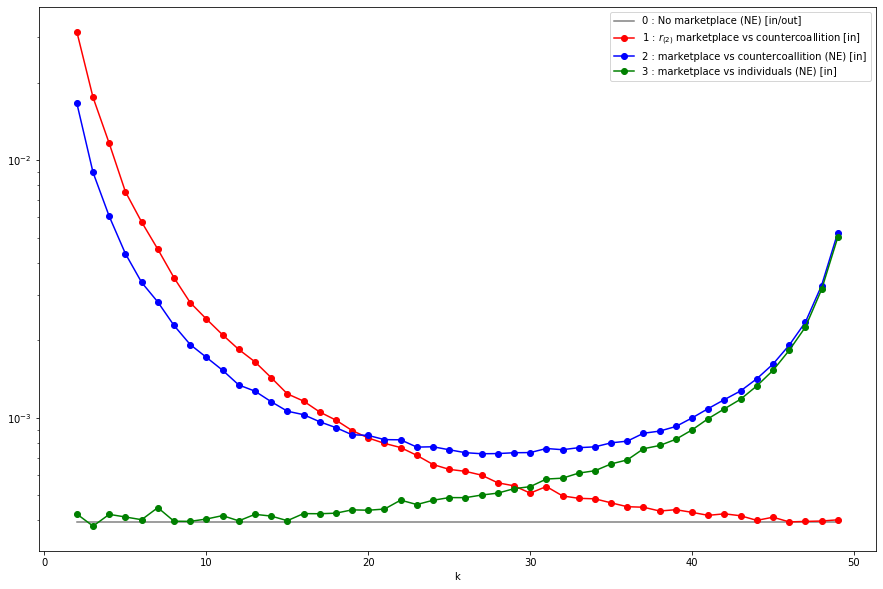

In [27]:
plt.figure(figsize=(15,10))
plt.xlabel("k")

plt.semilogy(k_,0*k_+1/(n*(n+1)),'-',color='gray',label="0 : No marketplace (NE) [in/out]")
plt.semilogy(k_,scenarios_[1]['in'],'-o',color='red',label=r"1 : $r_{(2)}$ marketplace vs countercoallition [in]")
plt.semilogy(k_,scenarios_[2]['in'],'-o',color='blue',label=r"2 : marketplace vs countercoallition (NE) [in]")
plt.semilogy(k_,scenarios_[3]['in'],'-o',color='green',label=r"3 : marketplace vs individuals (NE) [in]")

#plt.semilogy(k_,scenarios_[1]['out'],'-^',color='red',label=r"1 : $r_{(2)}$ marketplace vs countercoallition [out]")
#plt.semilogy(k_,scenarios_[2]['out'],'-^',color='blue',label=r"2 : marketplace vs countercoallition (NE) [out]")
#plt.semilogy(k_,scenarios_[3]['out'],'-^',color='green',label=r"3 : marketplace vs individuals (NE) [out]")

#plt.semilogy(k_,0*k_+(n-1)/(n+1),'-',color='gray',label="0 : No marketplace (NE) [auct]")
#plt.semilogy(k_,scenarios_[1]['auct'],'-+',color='red',label=r"1 : $r_{(2)}$ marketplace vs countercoallition [auct]")
#plt.semilogy(k_,scenarios_[2]['auct'],'-+',color='blue',label=r"2 : marketplace vs countercoallition (NE) [auct]")
#plt.semilogy(k_,scenarios_[3]['auct'],'-+',color='green',label=r"3 : marketplace vs individuals (NE) [auct]")

plt.legend()
plt.show()

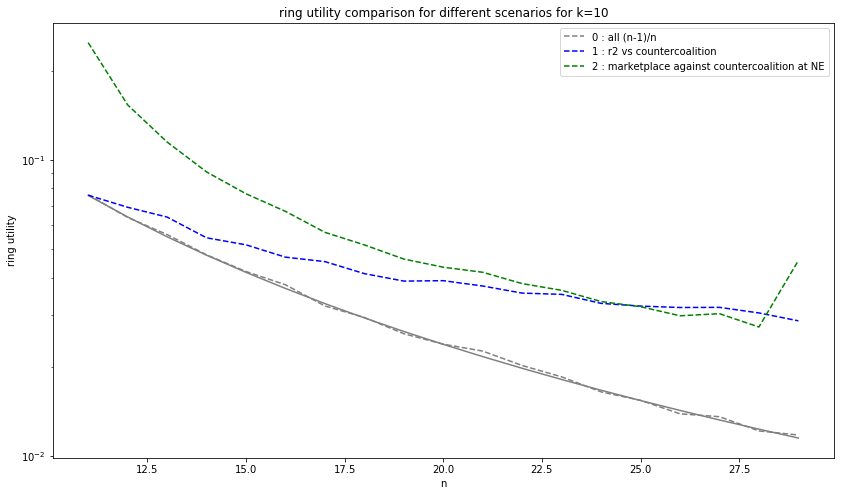

In [8]:
plt.figure(figsize=(14,8))
#,label='all NC bidders (use n-1/n)')
#plt.semilogy(k_,np.power((n/(n-1)),n-k_)*(k_-1)/(n-1)*k_*1/(n*(n+1)),color='red',label='r2 marketplace vs n-1/n ')
#plt.semilogy(k_,np.power((n/(n-1)),n-k_)*(k_-1)/(n-1)*k_*1/(n*(n+1)),color='gray')

#plt.ylim((0,0.02))
plt.semilogy(n_,test0_,'--',color='gray',label='0 : all (n-1)/n')
plt.semilogy(n_,k/(n_*(n_+1)),color='gray')
plt.semilogy(n_,test1_,'--',color='blue',label='1 : r2 vs countercoalition ')
plt.semilogy(n_,test2_,'--',color='green',label='2 : marketplace against countercoalition at NE')

plt.legend()
plt.ylabel("ring utility")
plt.xlabel("n")
plt.title("ring utility comparison for different scenarios for k={}".format(k))
plt.show()

## Old

In [171]:
batch_size = 100_000

#k = 10
#n_ = np.linspace(k+1,k+1000,100)
n=100
k_ = np.arange(2,n)

test0_ = []
test1_ = []
#test2_ = []
test3_ = []

for k in tqdm(k_) :
    
    #sampling
    v_out_ = stats.beta(a=n-k,b=1).rvs(size=batch_size)
    v_in_sub_ = np.sort(stats.uniform().rvs(size=batch_size*k).reshape(batch_size,k))[:,-2:]
    v_in_ = v_in_sub_[:,-1]
    
    #test0 = all the agents are nc, they use n-1/n strategy
    b0_in_ = (n-1)/n*v_in_
    b0_out_ = (n-1)/n*v_out_
    
    test0_.append(np.mean((v_in_-b0_in_)*(b0_in_>=b0_out_)))
    
    #test1 = internal agents use v_2, external use the n-1/n strategy
    b1_in_ = v_in_sub_[:,-2]
    
    b1_out_ = (n-1)/n*v_out_

    test1_.append(np.mean((v_in_-b1_in_)*(b1_in_>=b1_out_)))
    
    #test2 = internal agents use v_2, external use the best response against the marketplace
    #b2_in_ = v_in_sub_[:,-2]
    
    #strat = BR(stats.beta(a=k-1,b=2))
    #b2_out_ = np.array([strat(v) for v in  v_out_])
    
    #test2_.append(np.mean((v_in_-b2_in_)*(b2_in_>=b2_out_)))
    
    #test3 =  internal agents use best response against the outside agents, outside agents use the n-1/n strategy
    b3_in_ = (n-k)/(n-k+1)*v_in_ 
    b3_out_ = (n-1)/n*v_out_
    
    test3_.append(np.mean((v_in_-b3_in_)*(b3_in_>=b3_out_)))

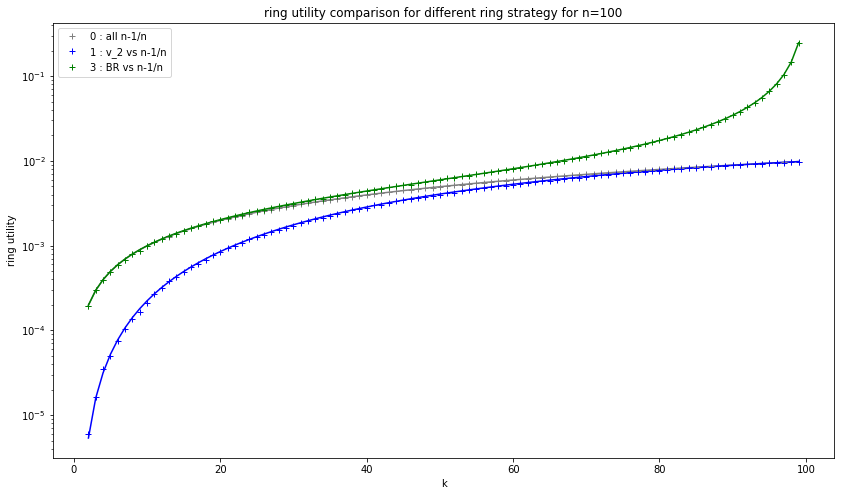

In [176]:
plt.figure(figsize=(14,8))
plt.semilogy(k_,k_/(n*(n+1)),color='gray')
plt.semilogy(k_,np.power((n/(n-1)),n-k_)*(k_-1)/(n-1)*k_*1/(n*(n+1)),color='blue')
plt.semilogy(k_,np.power((n*(n-k_))/((n-1)*(n-k_+1)),n-k_)*1/((n+1)*(n-k_+1))*k_,color='green')

#plt.ylim((0,0.02))
plt.semilogy(k_,test0_,'+',color='gray',label='0 : all n-1/n')
plt.semilogy(k_,test1_,'b+',label='1 : v_2 vs n-1/n')
#plt.semilogy(k_,test2_,'r--',label='2 : v_2  vs BR')
plt.semilogy(k_,test3_,'g+',label='3 : BR vs n-1/n')
plt.legend()
plt.ylabel("ring utility")
plt.xlabel("k")
plt.title("ring utility comparison for different ring strategy for n={}".format(n))
plt.show()

### $k=100$ fixed, $n$ varies

In [176]:
batch_size = 100_000

k = 100
n_ = k+np.linspace(1,3*k+1,101)

test0_ = []
test1_ = []
test2_ = []
#test3_ = []

for n in tqdm(n_) :
    
    #sampling
    v_out_ = stats.beta(a=n-k,b=1).rvs(size=batch_size)
    v_in_sub_ = np.sort(stats.uniform().rvs(size=batch_size*k).reshape(batch_size,k))[:,-2:]
    v_in_ = v_in_sub_[:,-1]
    
    #test0 = all the agents are nc, they use n-1/n strategy
    b0_in_ = (n-1)/n*v_in_
    b0_out_ = (n-1)/n*v_out_
    
    test0_.append(np.mean((v_in_-b0_in_)*(b0_in_>=b0_out_)))
    
    #test1 = internal agents use v_2, external use the n-1/n strategy
    b1_in_ = v_in_sub_[:,-2]
    
    b1_out_ = (n-1)/n*v_out_

    test1_.append(np.mean((v_in_-b1_in_)*(b1_in_>=b1_out_)))
    
    #test2 =  internal agents use best response against the outside agents, outside agents use the n-1/n strategy
    b2_in_ = (n-k)/(n-k+1)*v_in_
    b2_out_ = (n-1)/n*v_out_
    
    test2_.append(np.mean((v_in_-b2_in_)*(b2_in_>=b2_out_)))
    
    #test3 = internal agents use v_2, external use the best response against the marketplace
    #b3_in_ = v_in_sub_[:,-2]
    
    #strat = BR(stats.beta(a=k-1,b=2))
    #b3_out_ = np.array([strat(v) for v in  v_out_])
    
    #test3_.append(np.mean((v_in_-b3_in_)*(b3_in_>=b3_out_)))

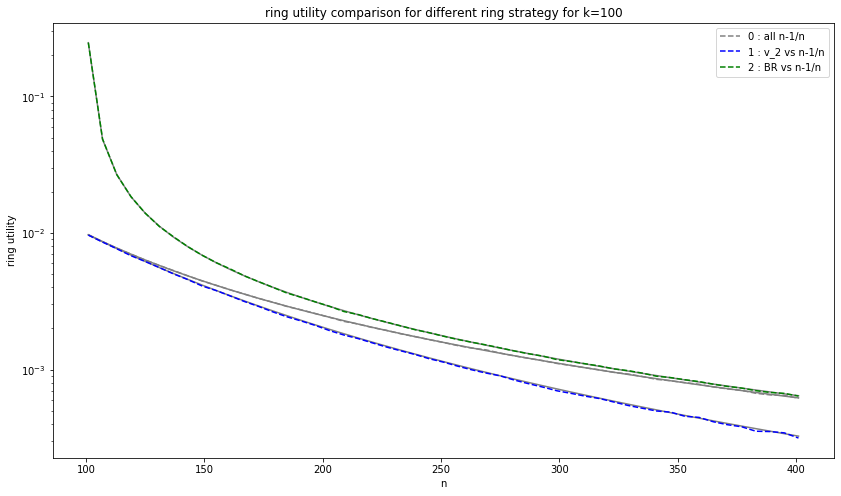

In [179]:
plt.figure(figsize=(14,8))
plt.semilogy(n_,k/(n_*(n_+1)),color='gray')
plt.semilogy(n_,np.power((n_/(n_-1)),n_-k)*(k-1)/(n_-1)*k*1/(n_*(n_+1)),color='gray')
plt.semilogy(n_,np.power((n_*(n_-k))/((n_-1)*(n_-k+1)),n_-k)*1/((n_+1)*(n_-k+1))*k,color='gray')

#plt.ylim((0,0.02))
plt.semilogy(n_,test0_,'--',color='gray',label='0 : all n-1/n')
plt.semilogy(n_,test1_,'b--',label='1 : v_2 vs n-1/n')
plt.semilogy(n_,test2_,'g--',label='2 : BR vs n-1/n')
#plt.semilogy(n_,test3_,'r--',label='3 : v_2  vs BR')
plt.legend()
plt.title("ring utility comparison for different ring strategy for k={}".format(k))
plt.ylabel('ring utility')
plt.xlabel('n')
plt.show()

### Shading competitions test

In [180]:
batch_size = 50_000

n=100
k_ = [10,25,50,75,95]
shading_ = np.linspace(0.85,1,101)

test0_ = []
test1_ = []
test2_ = []

for k in tqdm(k_) :
    test0_.append([])
    test1_.append([])
    test2_.append([])
    
    for s in shading_ :
        #sampling
        v_out_ = stats.beta(a=n-k,b=1).rvs(size=batch_size)
        v_in_sub_ = np.sort(stats.uniform().rvs(size=batch_size*k).reshape(batch_size,k))[:,-2:]
        v_in_ = v_in_sub_[:,-1]

        y_ = s*v_out_

        #test0 = all the agents are nc, they use n-1/n strategy
        b0_in_ = (n-1)/n*v_in_

        test0_[-1].append(np.mean((v_in_-b0_in_)*(b0_in_>=y_)))

        #test1 = internal agents use v_2, external use the n-1/n strategy
        b1_in_ = v_in_sub_[:,-2]

        test1_[-1].append(np.mean((v_in_-b1_in_)*(b1_in_>=y_)))

        #test3 =  internal agents use best response against the outside agents, outside agents use the n-1/n strategy
        b2_in_ = (n-k)/(n-k+1)*v_in_ 

        test2_[-1].append(np.mean((v_in_-b2_in_)*(b2_in_>=y_)))

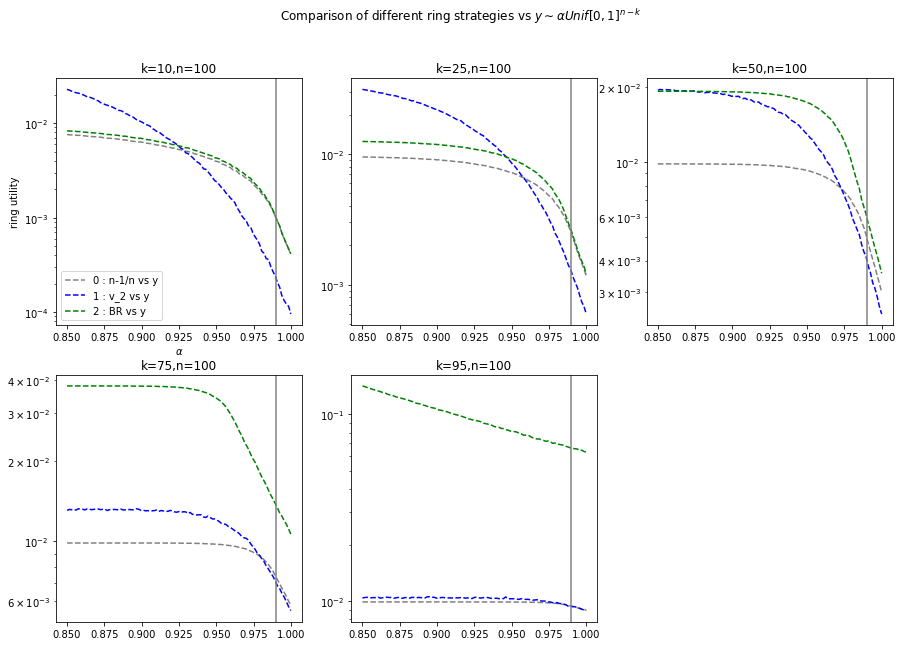

In [181]:
plt.figure(figsize=(15,10))
plt.suptitle(r'Comparison of different ring strategies vs $y\sim \alpha Unif[0,1]^{n-k}$')
for i in range(len(k_)) :
    plt.subplot(2, 3, i+1)
    plt.semilogy(shading_,test0_[i],'--',color='gray',label=r'0 : n-1/n vs y')
    plt.semilogy(shading_,test1_[i],'b--',label=r'1 : v_2 vs y')
    plt.semilogy(shading_,test2_[i],'g--',label=r'2 : BR vs y')
    plt.title("k={},n={}".format(k_[i],n))
    plt.axvline((n-1)/n,color='gray')
    if(i==0) :
        plt.xlabel(r'$\alpha$')
        plt.ylabel('ring utility')
        plt.legend()
plt.show()

### Lognorm tests

In [201]:
batch_size = 10000

k = 100
n_ = k+np.linspace(1,3*k+1,51)

test1_ = []
test2_ = []
test3_ = []
    
#sampling
y_ = stats.lognorm(1).rvs(size=batch_size)

v_in_sub_ = np.sort(stats.lognorm(1).rvs(size=batch_size*k).reshape(batch_size,k))[:,-2:]
v_in_ = v_in_sub_[:,-1]


#test1 = internal agents use v_2, external bid lognorm
b1_in_ = v_in_sub_[:,-2]

test1_.append(np.mean((v_in_-b1_in_)*(b1_in_>=y_)))

#test2 = internal agents use BR, external bid lognorm
strat = BR(stats.lognorm(1))
b2_in_ = np.array([strat(v) for v in  v_in_])

test2_.append(np.mean((v_in_-b2_in_)*(b2_in_>=y_)))

#test2 = internal agents bid random lognorm, external bid lognorm
b3_in_ = stats.lognorm(1).rvs(size=batch_size)

test3_.append(np.mean((v_in_-b3_in_)*(b3_in_>=y_)))

In [202]:
test1_

[0.004804978960107268]

In [203]:
test2_

[0.12123495082907937]

In [204]:
test3_

[-0.7459365607958878]